# WaveMixSR

#### Import Libraries

In [28]:
%pip install -q -r requirements.txt
# Note: the above installs the requirements in the requirements.txt file. pytorch and torchvision are requirements and it would install the CPU only version of these packages. 
# If your device has a CUDA GPU, remove 'torch' and 'torchvision' from the requirements.txt file and run the cell. Then visit https://pytorch.org/ to get the appropriate 
# pytorch version with CUDA support

Note: you may need to restart the kernel to use updated packages.


In [29]:
from datasets import load_dataset
from pathlib import Path
import random
import matplotlib.pyplot as plt
from torchsr.datasets import Div2K
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from PIL import Image
import os
import cv2
import numpy as np
import wavemix.sisr as sisr

In [64]:
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


#### Download data and get some insight into the data

In [65]:
# Define the path where you want to save the dataset
data_path = Path.cwd() / "data"
data_path.mkdir(parents=True, exist_ok=True)


dataset = Div2K(root=data_path, scale=2, download=False)

In [66]:
train_data_folder = data_path/"DIV2K/DIV2K_train_LR_bicubic/X2"
test_data_folder = data_path/"DIV2K/DIV2K_valid_LR_bicubic/X2"

train_data_targest_folder = data_path/"DIV2K/DIV2K_train_HR"
test_data_targest_folder = data_path/"DIV2K/DIV2K_valid_HR"

In [67]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    """Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr.

    Returns:
        torch.Tensor: YCbCr version of the image.
    """

    if not torch.is_tensor(image):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta = .5
    y: torch.Tensor = .299 * r + .587 * g + .114 * b
    cb: torch.Tensor = (b - y) * .564 + delta
    cr: torch.Tensor = (r - y) * .713 + delta
    return torch.stack((y, cb, cr), -3)

In [84]:
# Custom class for loading data

class CustomDataSet(Dataset):
    def __init__(self, lr_image_folder, hr_image_folder, transform=None):
        self.lr_image_folder = lr_image_folder
        self.hr_image_folder = hr_image_folder
        self.lr_image_files = os.listdir(lr_image_folder)
        self.hr_image_files = os.listdir(hr_image_folder)
        self.transform = transform

    def __len__(self):
        return len(self.lr_image_files)
    
    def __getitem__(self, idx):
        lr_image = cv2.cvtColor(cv2.imread(str(self.lr_image_folder/self.lr_image_files[idx])), cv2.COLOR_BGR2YCrCb)
        hr_image = cv2.cvtColor(cv2.imread(str(self.hr_image_folder/self.hr_image_files[idx])), cv2.COLOR_BGR2YCrCb)
        lr_image = torch.tensor(lr_image).permute(2, 0, 1).float() # Since OpenCV represents images as HWC and Pytorch expects them as CHW
        hr_image = torch.tensor(hr_image).permute(2, 0, 1).float()
        return lr_image, hr_image

Number of training samples: 800


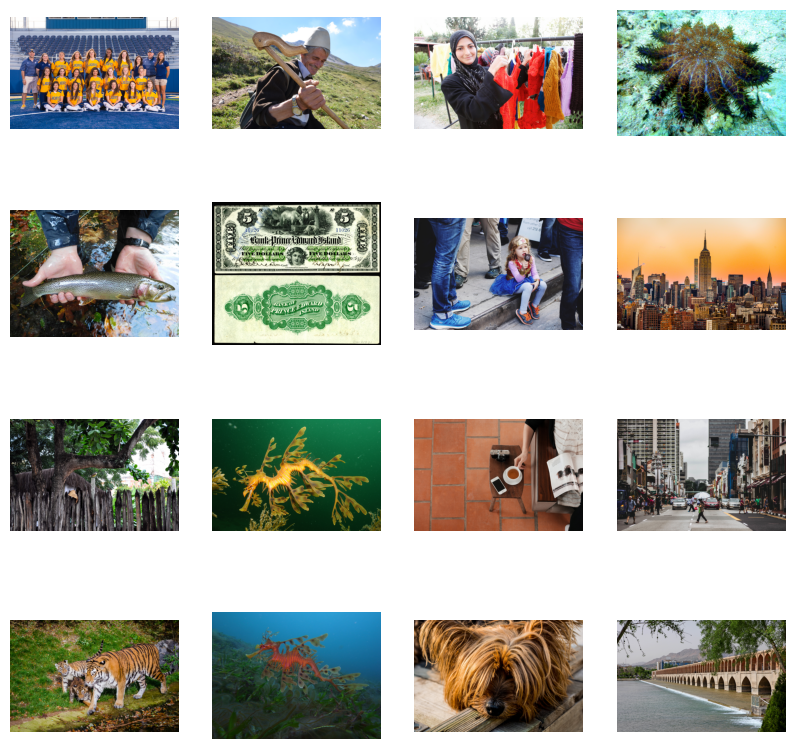

In [86]:
# Visualize random data

train_dataset = CustomDataSet(lr_image_folder=train_data_folder, 
                              hr_image_folder=train_data_targest_folder,
                              )
test_dataset = CustomDataSet(lr_image_folder=test_data_folder,
                             hr_image_folder=test_data_targest_folder)

# Plot random images
print(f"Number of training samples: {len(train_dataset)}")
random_indices = random.sample(range(len(train_dataset)), 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_dataset[idx][0]
    ax = axs[i//4, i%4]
    ax.imshow(cv2.cvtColor(np.asarray(img.permute(1,2,0).type(torch.uint8)), cv2.COLOR_YCrCb2RGB))
    ax.axis("off")
plt.show()

In [81]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [74]:
class WaveMixSR(nn.Module):
    def __init__(
        self,
        *,
        depth,
        mult = 1,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.3,
        scale_factor = 2
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(sisr.Level1Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))
        
        self.final = nn.Sequential(
            nn.Conv2d(final_dim,int(final_dim/2), 3, stride=1, padding=1),
            nn.Conv2d(int(final_dim/2), 1, 1)
        )


        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners = False),
            nn.Conv2d(1, int(final_dim/2), 3, 1, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 1, 1)
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=int(scale_factor), mode='bilinear', align_corners = False),
        )

    def forward(self, img):

        y = img[:, 0:1, :, :] 
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)


        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)
        
        return  torch.cat((y,crcb), dim=1)



In [75]:
model = WaveMixSR(
    depth = 4,
    mult = 1,
    ff_channel = 144,
    final_dim = 144,
    dropout = 0.3
)


In [83]:
image = next(iter(train_loader))[0]
print(f"Input image shape: {image.shape}")
# print(f"Upsampled image shape: {upsampled_image.shape}")

Input image shape: torch.Size([1, 3, 2040, 2040])
